In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score

In [2]:
df = pd.read_parquet('data/processed_data/balanced_train.parquet')
df = df[['protein_name', 'binds']]
df

,protein_name,binds
0,BRD4,0
1,HSA,1
2,sEH,1
3,sEH,0
4,BRD4,1
...,...,...
3179807,sEH,0
3179808,BRD4,0
3179809,BRD4,0
3179810,sEH,0


In [3]:
df = pd.concat([df, pd.get_dummies(df['protein_name'], dtype=int)], axis=1)
df = df.drop(columns=['protein_name'])
df = df[['BRD4', 'HSA', 'sEH', 'binds']]
df

,BRD4,HSA,sEH,binds
0,1,0,0,0
1,0,1,0,1
2,0,0,1,1
3,0,0,1,0
4,1,0,0,1
...,...,...,...,...
3179807,0,0,1,0
3179808,1,0,0,0
3179809,1,0,0,0
3179810,0,0,1,0


In [4]:
protein_arr = np.array(df[['BRD4', 'HSA', 'sEH']])
protein_arr = protein_arr.astype(np.uint8)
protein_arr.shape, protein_arr.dtype

((3179812, 3), dtype('uint8'))

In [5]:
y = df['binds'].values
del df
y = y.astype(np.uint8)
y.shape, y.dtype

((3179812,), dtype('uint8'))

In [6]:
ecfp = np.load('data/processed_data/ecfp.npy')
ecfp.shape, y.dtype

((3179812, 1024), dtype('uint8'))

In [7]:
X = np.concatenate((ecfp, protein_arr), axis=1)
X.shape, X.dtype

((3179812, 1027), dtype('uint8'))

In [8]:
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

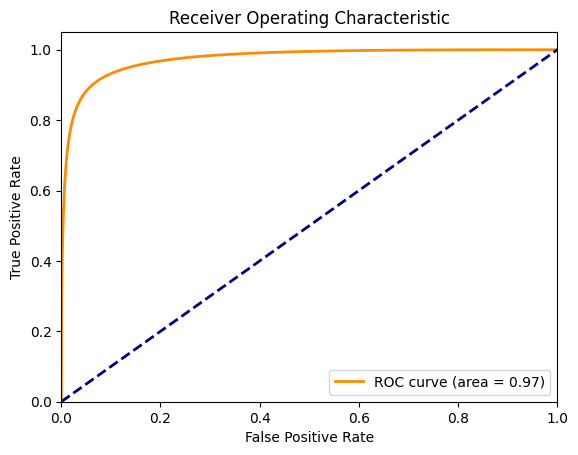

In [9]:
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
ecfp_test = np.load('data/processed_data/ecfp_test.npy')
ecfp_test.shape, y.dtype

((1674896, 1024), dtype('uint8'))

In [24]:
test_df = pd.read_parquet('data/test.parquet')
test_df

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
0,295246830,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,BRD4
1,295246831,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,HSA
2,295246832,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,sEH
3,295246833,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,BRD4
4,295246834,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,HSA
...,...,...,...,...,...,...
1674891,296921721,[N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc...,Nc1noc2ccc(F)cc12,COC1CCC(CCN)CC1,COC1CCC(CCNc2nc(Nc3noc4ccc(F)cc34)nc(N[C@@H](C...,HSA
1674892,296921722,[N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc...,Nc1noc2ccc(F)cc12,COC1CCC(CCN)CC1,COC1CCC(CCNc2nc(Nc3noc4ccc(F)cc34)nc(N[C@@H](C...,sEH
1674893,296921723,[N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc...,Nc1noc2ccc(F)cc12,NCc1cccs1,[N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cccs2)nc(Nc2noc3...,BRD4
1674894,296921724,[N-]=[N+]=NCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc...,Nc1noc2ccc(F)cc12,NCc1cccs1,[N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cccs2)nc(Nc2noc3...,HSA


In [26]:
ids = test_df['id'].values
ids[:20], ids.shape

(array([295246830, 295246831, 295246832, 295246833, 295246834, 295246835,
        295246836, 295246837, 295246838, 295246839, 295246840, 295246841,
        295246842, 295246843, 295246844, 295246845, 295246846, 295246847,
        295246848, 295246849]),
 (1674896,))

In [27]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['protein_name'], dtype=int)], axis=1)
test_df = test_df.drop(columns=['protein_name'])
test_df = test_df[['BRD4', 'HSA', 'sEH']]
test_df

,BRD4,HSA,sEH
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
1674891,0,1,0
1674892,0,0,1
1674893,1,0,0
1674894,0,1,0


In [28]:
protein_arr = np.array(test_df[['BRD4', 'HSA', 'sEH']])
protein_arr = protein_arr.astype(np.uint8)
protein_arr.shape, protein_arr.dtype

((1674896, 3), dtype('uint8'))

In [29]:
X_test = np.concatenate((ecfp_test, protein_arr), axis=1)
X_test.shape, X_test.dtype

((1674896, 1027), dtype('uint8'))

In [30]:
arr = model.predict_proba(X_test)[:,1]
arr[:20]

array([0.2396613 , 0.16124244, 0.06558087, 0.35916284, 0.4494909 ,
       0.21514212, 0.29200345, 0.09815084, 0.07845946, 0.19954659,
       0.18833746, 0.05717932, 0.22968338, 0.2093791 , 0.26079684,
       0.5329133 , 0.2602515 , 0.19674996, 0.3170857 , 0.22740844],
      dtype=float32)

In [31]:
submission_df = pd.DataFrame({'id': ids, 'binds': arr})
submission_df

,id,binds
0,295246830,0.239661
1,295246831,0.161242
2,295246832,0.065581
3,295246833,0.359163
4,295246834,0.449491
...,...,...
1674891,296921721,0.040922
1674892,296921722,0.043073
1674893,296921723,0.070381
1674894,296921724,0.053542


In [32]:
submission_df.to_csv('data/2024_04_25.csv', index=False)